In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error,mean_squared_log_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tabulate import tabulate
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [120]:
df=pd.read_csv('https://raw.githubusercontent.com/CallMePo/Final-Project-PMA/master/KepRiau%202015%20-%202022.csv ')
df

,datetime,total_visitor,total_accomodation
0,1/1/2014,164430,10055
1,2/1/2014,137055,10079
2,3/1/2014,167030,10132
3,4/1/2014,151982,10190
4,5/1/2014,154299,10274
...,...,...,...
103,8/1/2022,79470,15449
104,9/1/2022,104652,15502
105,10/1/2022,106160,15525
106,11/1/2022,103940,15612


In [121]:
df.isna().sum()

datetime              0
total_visitor         0
total_accomodation    0
dtype: int64

In [122]:
train_datetime=pd.to_datetime(df['datetime'])
train_datetime

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]

In [123]:
selected_columns = ['total_visitor','total_accomodation']
data_train = df.loc[:, selected_columns].astype(float)

In [124]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_train)

In [125]:
n_future=1
n_step=12

X_train=[]
y_train=[]
for i in range (n_step, len(data_scaled)-n_future+1):
    past_data = data_scaled[i-n_step:i, 0:data_scaled.shape[1]]
    future_data=data_scaled[i+n_future - 1:i +n_future,0]
    
    X_train.append(past_data)
    y_train.append(future_data)

X_train=np.array(X_train)
y_train=np.array(y_train)

TEST SIZE 80:20

In [126]:
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [127]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(76, 12, 2)
(76, 1)
(20, 12, 2)
(20, 1)


In [128]:
model=Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))

In [129]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 64)                4288      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4353 (17.00 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [130]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [131]:
history=model.fit(X_train,y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


3/3 [==============================] - 1s 0s/step - loss: 0.2573
Epoch 2/100
3/3 [==============================] - 0s 0s/step - loss: 0.0733
Epoch 3/100
3/3 [==============================] - 0s 0s/step - loss: 0.0715
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0397
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 0.0382
Epoch 6/100
3/3 [==============================] - 0s 0s/step - loss: 0.0279
Epoch 7/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0250
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0228
Epoch 10/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0182
Epoch 11/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 12/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 13/100
3/3 [==============================] - 0s 0s/step - loss: 0.0192

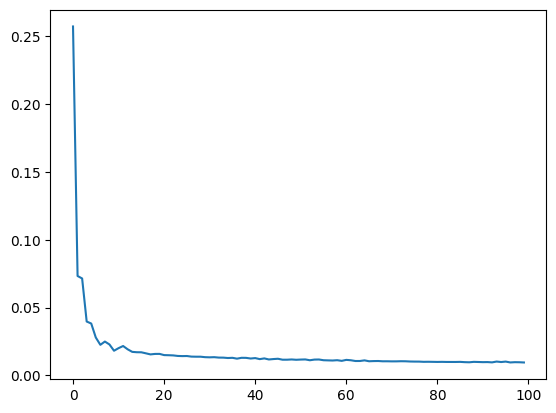

In [132]:
plt.plot(history.history['loss'])

In [133]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [134]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 161ms/step
mse: 0.005877431276221011
rmse 0.07666440684059984
MAPE: 5.89%
mae 0.06123290103793421


In [135]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_15612\1499544800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppD

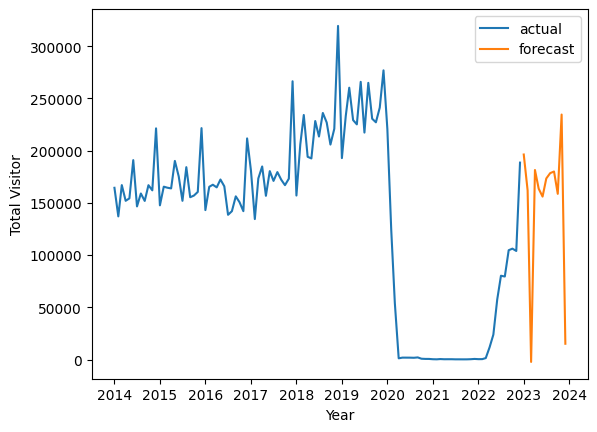

In [136]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [137]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │    196304    │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │    161944    │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     -2317.03 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │    181461    │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │    163540    │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │    156010    │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │    173384    │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │    178457    │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │    180043    │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │    158651    │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │    234575    │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

TEST SIZE 70:30

In [138]:
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.3, random_state=42)


In [139]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(53, 12, 2)
(53, 1)
(23, 12, 2)
(23, 1)


In [140]:
model=Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))

In [141]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 64)                4288      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4353 (17.00 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [142]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [143]:
history=model.fit(X_train,y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


2/2 [==============================] - 1s 0s/step - loss: 0.1318
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0956
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0298
Epoch 4/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0387
Epoch 5/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0486
Epoch 6/100
2/2 [==============================] - 0s 0s/step - loss: 0.0231
Epoch 7/100
2/2 [==============================] - 0s 645us/step - loss: 0.0234
Epoch 8/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0275
Epoch 9/100
2/2 [==============================] - 0s 0s/step - loss: 0.0177
Epoch 10/100
2/2 [==============================] - 0s 422us/step - loss: 0.0137
Epoch 11/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0190
Epoch 12/100
2/2 [==============================] - 0s 0s/step - loss: 0.0191
Epoch 13/100
2/2 [==============================] - 0s 2ms/step - los

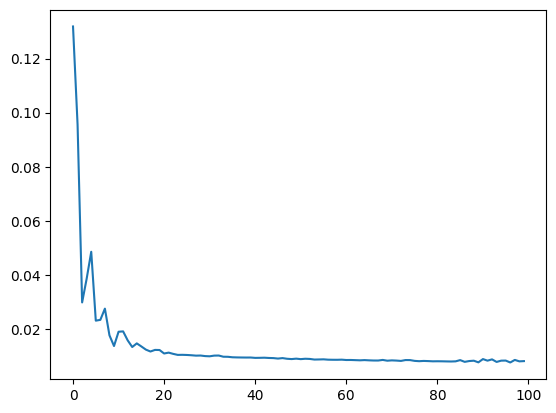

In [144]:
plt.plot(history.history['loss'])

In [145]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [146]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 169ms/step
mse: 0.01919864544401768
rmse 0.13855917668641685
MAPE: 33.83%
mae 0.10067040920576624


In [147]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_15612\1499544800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppD

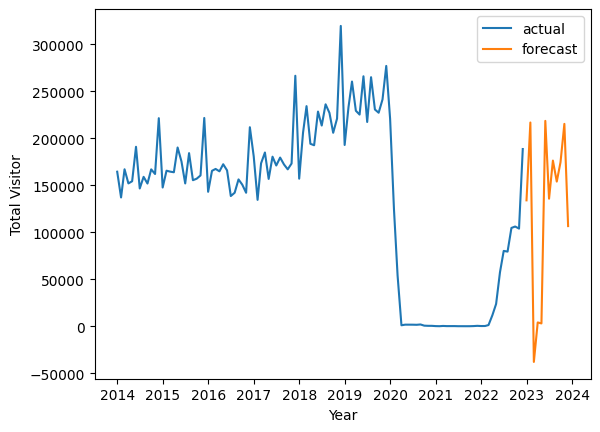

In [148]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [149]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │    133986    │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │    216753    │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │    -37825.6  │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │      4146.72 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │      3099.7  │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │    218478    │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │    135741    │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │    176242    │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │    153915    │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │    174517    │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │    215289    │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

TEST SIZE 60:40

In [150]:
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.4, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31, 12, 2)
(31, 1)
(22, 12, 2)
(22, 1)


In [151]:
model=Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 64)                4288      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4353 (17.00 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [152]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [153]:
history=model.fit(X_train,y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


1/1 [==============================] - 1s 1s/step - loss: 0.1622
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0204
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0489
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.0752
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0538
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 7/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0197
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0287
Epoch 10/100
1/1 [==============================] - 0s 0s/step - loss: 0.0345
Epoch 11/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0341
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 13/100
1/1 [==============================] - 0s 20ms/step - loss

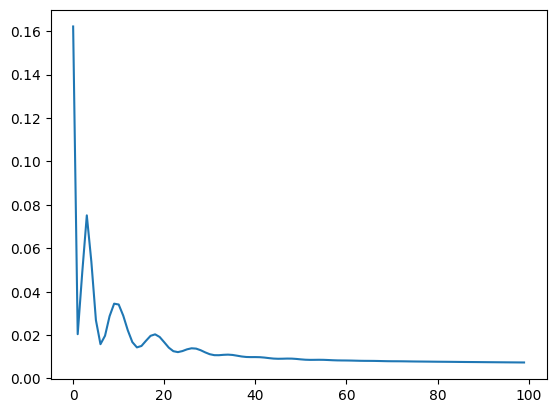

In [154]:
plt.plot(history.history['loss'])

In [155]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [156]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 143ms/step
mse: 0.023273237907295175
rmse 0.15255568788903012
MAPE: 5.77%
mae 0.1233313344853046


In [157]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_15612\1499544800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppD

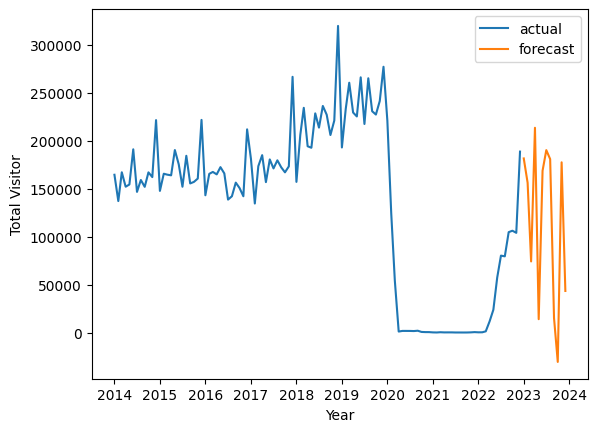

In [158]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [159]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     181433   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     156085   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │      74152   │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     213372   │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │      14013   │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     168636   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     190091   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │     180742   │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │      15324.8 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     -30497.5 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     177393   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  